In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

import ot
from scipy.spatial.distance import cdist

from scipy.stats import multivariate_normal as mvn
from matplotlib import cm

In [2]:
# from sklearn.datasets import fetch_openml

# # Load MNIST dataset using scikit-learn
# mnist = fetch_openml('mnist_784')

# # Extract features and labels
# images, labels = mnist.data, mnist.target

# np.save("data_files//mnist_data.npy", np.array(images.values))
# np.save("data_files//mnist_labels.npy", np.array(labels.values))

In [3]:
data_folder = r'D:\MNIST-digits/'

images = np.load(data_folder+"mnist_data.npy")
labels = np.load(data_folder+"mnist_labels.npy", allow_pickle=True)

In [4]:
image_list = [image.reshape(28,28) for i, image in enumerate(images) if labels[i] =='5']

In [5]:
class measure():
    
    def __init__(self, weights, locations):
        self.weights = weights
        self.locations = locations
    
    #For images
    def imshow(self):
        plt.imshow(self.weights.reshape(28,28), cmap=cm.hot_r)
        
    #For point clouds
    def plot_barycenter(self):
        est = np.zeros((28,28))

        for i in range(28):
            for j in range(28):
                #Estimate measure on grid using Gaussian Kernels
                est[i,j] = np.sum(mvn.pdf(self.locations, mean=[i,j],cov=np.eye(2))*self.weights)
                
        plt.imshow(est, cmap=cm.hot_r)
        
        
        
def locations_update(barycenter, measure_list, Pi_list):
        
    return np.mean(np.array([measure_list[i].locations.T@Pi_list[i].T@np.diag(1/barycenter.weights.reshape(-1)) for i in range(len(measure_list))]),0).T

    
def free_support_barycenter_update(measure_list, barycenter=None, N=20):
    
    if barycenter==None:
        init_weights = np.ones((N,1))/N
        init_locations = np.zeros(3)+np.random.normal(size=(N,3))
        barycenter = measure(init_weights, init_locations)
        
    else:
    
        result_list = [wasserstein_type_distance(barycenter, measure) for measure in measure_list]
        Pi_list = [result[1][0] for result in result_list]
        alpha_list = [ot.lp.center_ot_dual(result[1][1]['u'],result[1][1]['v'])[0] for result in result_list]
        
        barycenter.means_ = means_update(barycenter, measure_list, Pi_list)
        barycenter.covariances_ = covariance_update(space, barycenter, measure_list, Pi_list)
        
        barycenter.weights_ = weights_update(barycenter, alpha_list)
    
    return barycenter


def weights_update(barycenter, alpha_list, lr=0.00005):
    
    #get subgradient
    alpha = np.mean(np.array(alpha_list),0)

    #calculate subgradient update
    a_star = barycenter.weights+(lr*alpha.reshape(1,-1))

    #project a_star into (interior of) probability simplex
    a_star[a_star<0]=0.000001
    a = a_star/np.sum(a_star)
    
    return a.reshape(-1)
        
class measure_network():
    
    def __init__(self, weights, locations, sigma=1,eps=1e-15):
        self.weights = weights
        self.locations = locations
        self.D = cdist(self.locations,self.locations)
        
        
        self.eps=eps
        self.sigma = sigma 
        self.C = np.exp(-self.D ** 2 / (2 * self.sigma ** 2))
        
    def plot_graph(self):
        self.C = np.exp(-self.D ** 2 / (2 * self.sigma ** 2))
        # Plot nodes
        plt.scatter(self.locations[:, 1],-self.locations[:, 0], color='skyblue', alpha = self.weights/max(self.weights))

        # Plot edges
        for i in range(self.C.shape[0]-1):
            if self.weights[i]>0:
                for j in range(i + 1, self.C.shape[0]):
                    if self.weights[j]>0 and self.C[i,j]>self.eps:
                        plt.plot([self.locations[i, 1], self.locations[j, 1]], [-self.locations[i, 0], -self.locations[j, 0]], color='gray', alpha=self.C[i, j])

        # i, j = np.tril_indices(self.C.shape[0], k=-1)
        # plt.plot(np.c_[self.locations[i, 1], self.locations[j, 1]].T, -np.c_[self.locations[i, 0], self.locations[j, 0]].T, color='gray', alpha=self.C[i, j])

In [6]:
D = np.zeros((2,28,28))
for i in range(28):
    for j in range(28):
        
        D[:,i,j] = np.array([i,j])
        
coords = D.reshape(2,28*28).T

M = np.square(cdist(coords,coords))     

In [7]:
measure_list = [measure((image/np.sum(image)).flatten(), coords) for image in image_list if np.sum(image)>0][:500]

22.1 19.07 18.89 18.17 18.11 18.29 17.87 17.92 17.84 17.75 

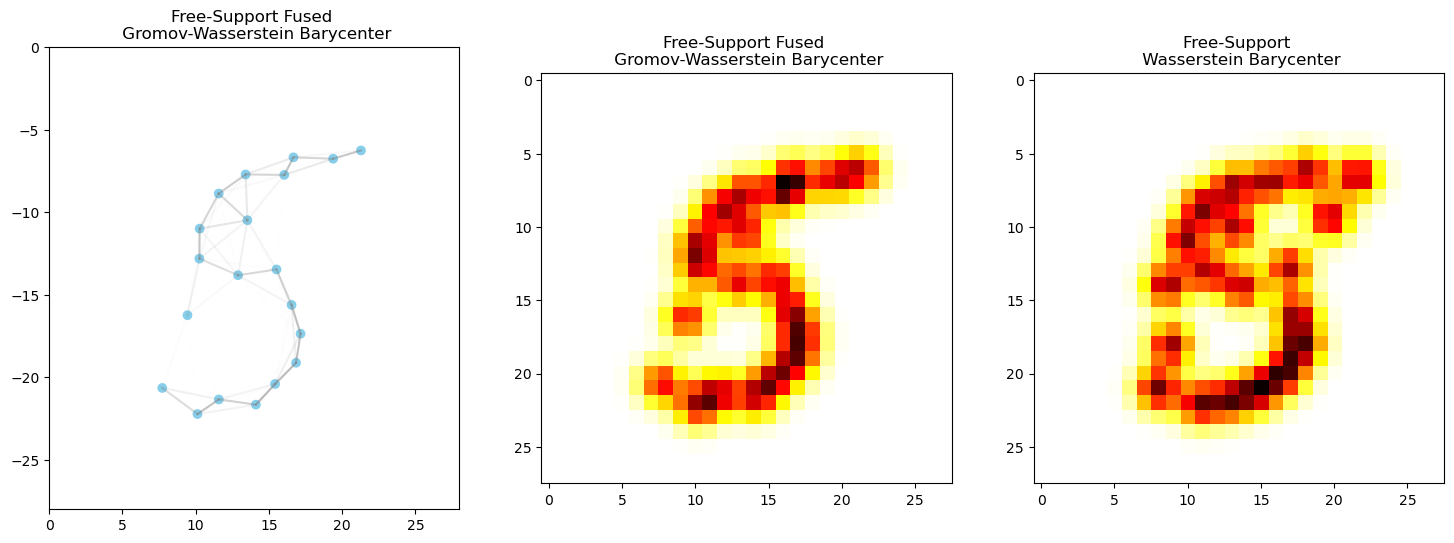

In [8]:
from time import time

for N in [20]:#np.concatenate([np.arange(2,22,2),[30,40,50]]):
    barycenter = measure(np.ones(N)/N, np.random.rand(N,2)*28)
    #Plot initial barycenter

    test = barycenter
    M=np.square(cdist(test.locations,coords))
    a=test.weights

    for i in range(10):

        result_list = [(M,ot.emd(test.weights,measure.weights,M,log=True)) for measure in measure_list]
        Pi_list = [result[1][0] for result in result_list]
        alpha_list = [ot.lp.center_ot_dual(result[1][1]['u'],result[1][1]['v'])[0] for result in result_list]

        test.locations = locations_update(test, measure_list, Pi_list)   
        test.weights = weights_update(test, alpha_list)

        M=np.square(cdist(test.locations,coords))


    #for later plotting
    barycente2r0 = test
    M0 = M

    barycenter2 = measure(np.ones(N)/N, np.random.rand(N,2)*28)
    mu20 = measure_network(barycenter2.weights,barycenter2.locations,sigma=2)

    for j in range(10):
        t0 = time()
        nodes20 = []
        edges20 = []

        a=mu20.weights
        A = mu20.D
        n=a.shape[0]

        for i, measure_i in enumerate(measure_list):

            
            mu1 = measure_network(measure_i.weights, measure_i.locations,sigma=2)

            b=mu1.weights
            b=b[mu1.weights>0]
            B = mu1.D[mu1.weights>0][:,mu1.weights>0]
            m=b.shape[0]
            Y=mu1.locations[mu1.weights>0]

            gamma = ot.fused_gromov_wasserstein(cdist(mu20.locations,Y), A, B, a, b, 'square_loss', alpha=.5, tol_rel=1e-9)

            Tx = np.diag(1/a)@gamma@Y
            Te = np.einsum('ij,kl,jl->ik', gamma/a[:, None], gamma/a[:, None], B)

            nodes20.append(Tx)                     
            edges20.append(Te)

        T_node = np.array(nodes20).mean(0)
        T_edge = np.array(edges20).mean(0)

        mu20 = measure_network(mu20.weights,T_node,sigma=2)
        mu20.D = T_edge
        
        print(round((time()-t0),2), end=' ')

    plt.figure(figsize=(18,6))

    plt.subplot(1,3,1)
    mu20.plot_graph()
    plt.title("Free-Support Fused \n Gromov-Wasserstein Barycenter")
    plt.xlim(0,28)
    plt.ylim(-28,0)

    plt.subplot(1,3,2)
    measure(mu20.weights, mu20.locations).plot_barycenter()
    plt.title("Free-Support Fused \n Gromov-Wasserstein Barycenter")

    plt.subplot(1,3,3)
    barycenter.plot_barycenter()
    plt.title("Free-Support \n Wasserstein Barycenter")

    plt.show()

76.28 71.05 64.09 64.38 63.29 63.17 63.34 63.03 64.16 63.08 

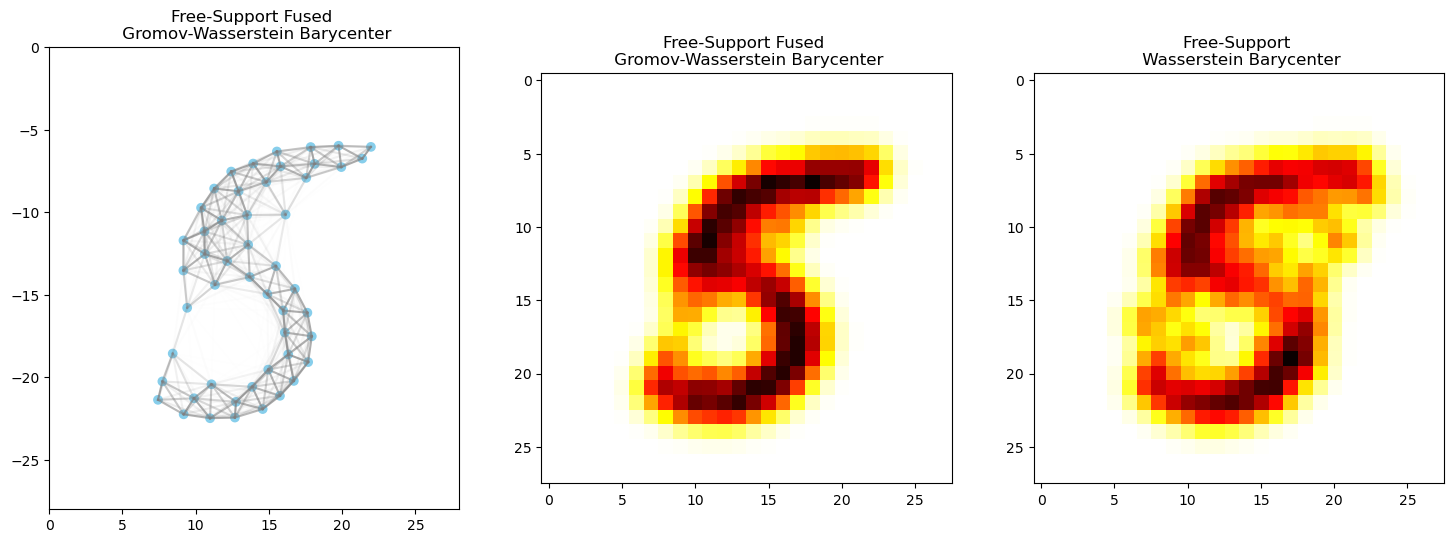

In [9]:
from time import time

for N in [50]:
    barycenter = measure(np.ones(N)/N, np.random.rand(N,2)*28)
    #Plot initial barycenter

    test = barycenter
    M=np.square(cdist(test.locations,coords))
    a=test.weights

    for i in range(10):

        result_list = [(M,ot.emd(test.weights,measure.weights,M,log=True)) for measure in measure_list]
        Pi_list = [result[1][0] for result in result_list]
        alpha_list = [ot.lp.center_ot_dual(result[1][1]['u'],result[1][1]['v'])[0] for result in result_list]

        test.locations = locations_update(test, measure_list, Pi_list)   
        test.weights = weights_update(test, alpha_list)

        M=np.square(cdist(test.locations,coords))


    #for later plotting
    barycenter50 = test
    M0 = M

    barycenter2 = measure(np.ones(N)/N, np.random.rand(N,2)*28)
    mu50 = measure_network(barycenter2.weights,barycenter2.locations,sigma=2)

    for j in range(10):
        t0 = time()
        nodes50 = []
        edges50 = []

        a=mu50.weights
        A = mu50.D
        n=a.shape[0]

        for i, measure_i in enumerate(measure_list):

            
            mu1 = measure_network(measure_i.weights, measure_i.locations,sigma=2)

            b=mu1.weights
            b=b[mu1.weights>0]
            B = mu1.D[mu1.weights>0][:,mu1.weights>0]
            m=b.shape[0]
            Y=mu1.locations[mu1.weights>0]

            gamma = ot.fused_gromov_wasserstein(cdist(mu50.locations,Y), A, B, a, b, 'square_loss', alpha=.5, tol_rel=1e-9)

            Tx = np.diag(1/a)@gamma@Y
            Te = np.einsum('ij,kl,jl->ik', gamma/a[:, None], gamma/a[:, None], B)

            nodes50.append(Tx)                     
            edges50.append(Te)

        T_node = np.array(nodes50).mean(0)
        T_edge = np.array(edges50).mean(0)

        mu50 = measure_network(mu50.weights,T_node,sigma=2)
        mu50.D = T_edge
        
        print(round((time()-t0),2), end=' ')

    plt.figure(figsize=(18,6))

    plt.subplot(1,3,1)
    mu50.plot_graph()
    plt.title("Free-Support Fused \n Gromov-Wasserstein Barycenter")
    plt.xlim(0,28)
    plt.ylim(-28,0)

    plt.subplot(1,3,2)
    measure(mu50.weights, mu50.locations).plot_barycenter()
    plt.title("Free-Support Fused \n Gromov-Wasserstein Barycenter")

    plt.subplot(1,3,3)
    barycenter.plot_barycenter()
    plt.title("Free-Support \n Wasserstein Barycenter")

    plt.show()

512.27 472.88 466.19 465.84 463.04 466.32 464.94 474.65 468.38 469.69 

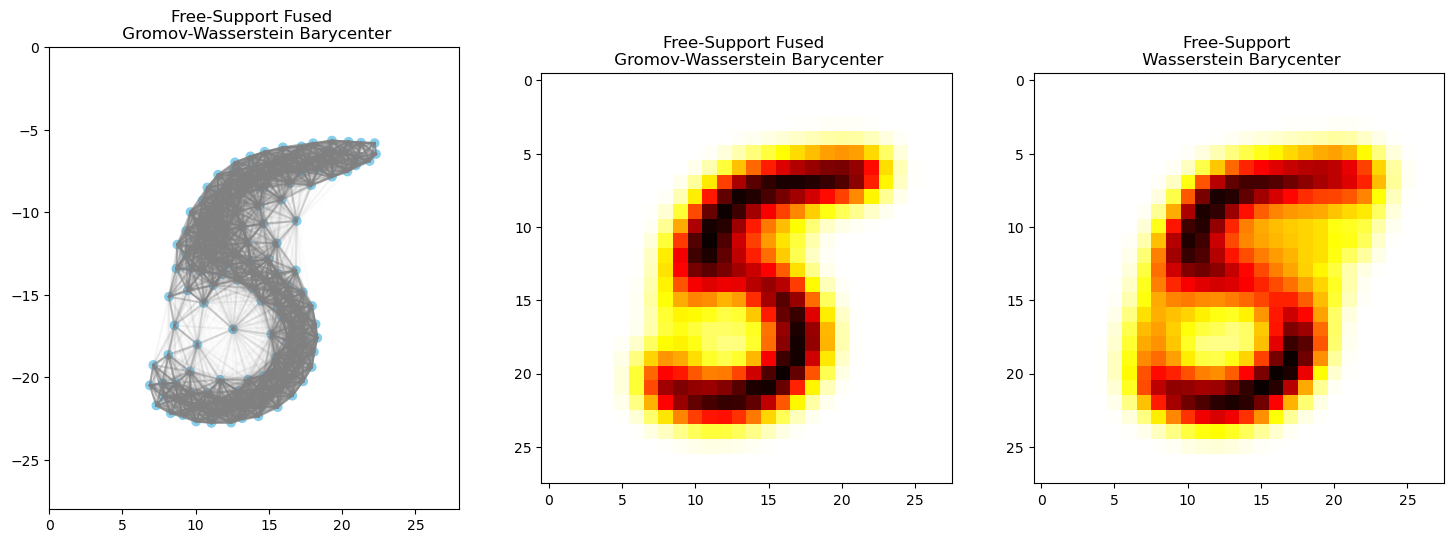

In [10]:
from time import time

for N in [150]:
    barycenter = measure(np.ones(N)/N, np.random.rand(N,2)*28)
    #Plot initial barycenter

    test = barycenter
    M=np.square(cdist(test.locations,coords))
    a=test.weights

    for i in range(10):

        result_list = [(M,ot.emd(test.weights,measure.weights,M,log=True)) for measure in measure_list]
        Pi_list = [result[1][0] for result in result_list]
        alpha_list = [ot.lp.center_ot_dual(result[1][1]['u'],result[1][1]['v'])[0] for result in result_list]

        test.locations = locations_update(test, measure_list, Pi_list)   
        test.weights = weights_update(test, alpha_list)

        M=np.square(cdist(test.locations,coords))


    #for later plotting
    barycenter150 = test
    M0 = M

    barycenter2 = measure(np.ones(N)/N, np.random.rand(N,2)*28)
    mu150 = measure_network(barycenter2.weights,barycenter2.locations,sigma=2)

    for j in range(10):
        t0 = time()
        nodes150 = []
        edges150 = []

        a=mu150.weights
        A = mu150.D
        n=a.shape[0]

        for i, measure_i in enumerate(measure_list):

            
            mu1 = measure_network(measure_i.weights, measure_i.locations,sigma=2)

            b=mu1.weights
            b=b[mu1.weights>0]
            B = mu1.D[mu1.weights>0][:,mu1.weights>0]
            m=b.shape[0]
            Y=mu1.locations[mu1.weights>0]

            gamma = ot.fused_gromov_wasserstein(cdist(mu150.locations,Y), A, B, a, b, 'square_loss', alpha=.5, tol_rel=1e-9)

            Tx = np.diag(1/a)@gamma@Y
            Te = np.einsum('ij,kl,jl->ik', gamma/a[:, None], gamma/a[:, None], B)

            nodes150.append(Tx)                     
            edges150.append(Te)

        T_node = np.array(nodes150).mean(0)
        T_edge = np.array(edges150).mean(0)

        mu150 = measure_network(mu150.weights,T_node,sigma=2)
        mu150.D = T_edge
        
        print(round((time()-t0),2), end=' ')

    plt.figure(figsize=(18,6))

    plt.subplot(1,3,1)
    mu150.plot_graph()
    plt.title("Free-Support Fused \n Gromov-Wasserstein Barycenter")
    plt.xlim(0,28)
    plt.ylim(-28,0)

    plt.subplot(1,3,2)
    measure(mu150.weights, mu150.locations).plot_barycenter()
    plt.title("Free-Support Fused \n Gromov-Wasserstein Barycenter")

    plt.subplot(1,3,3)
    barycenter.plot_barycenter()
    plt.title("Free-Support \n Wasserstein Barycenter")

    plt.show()

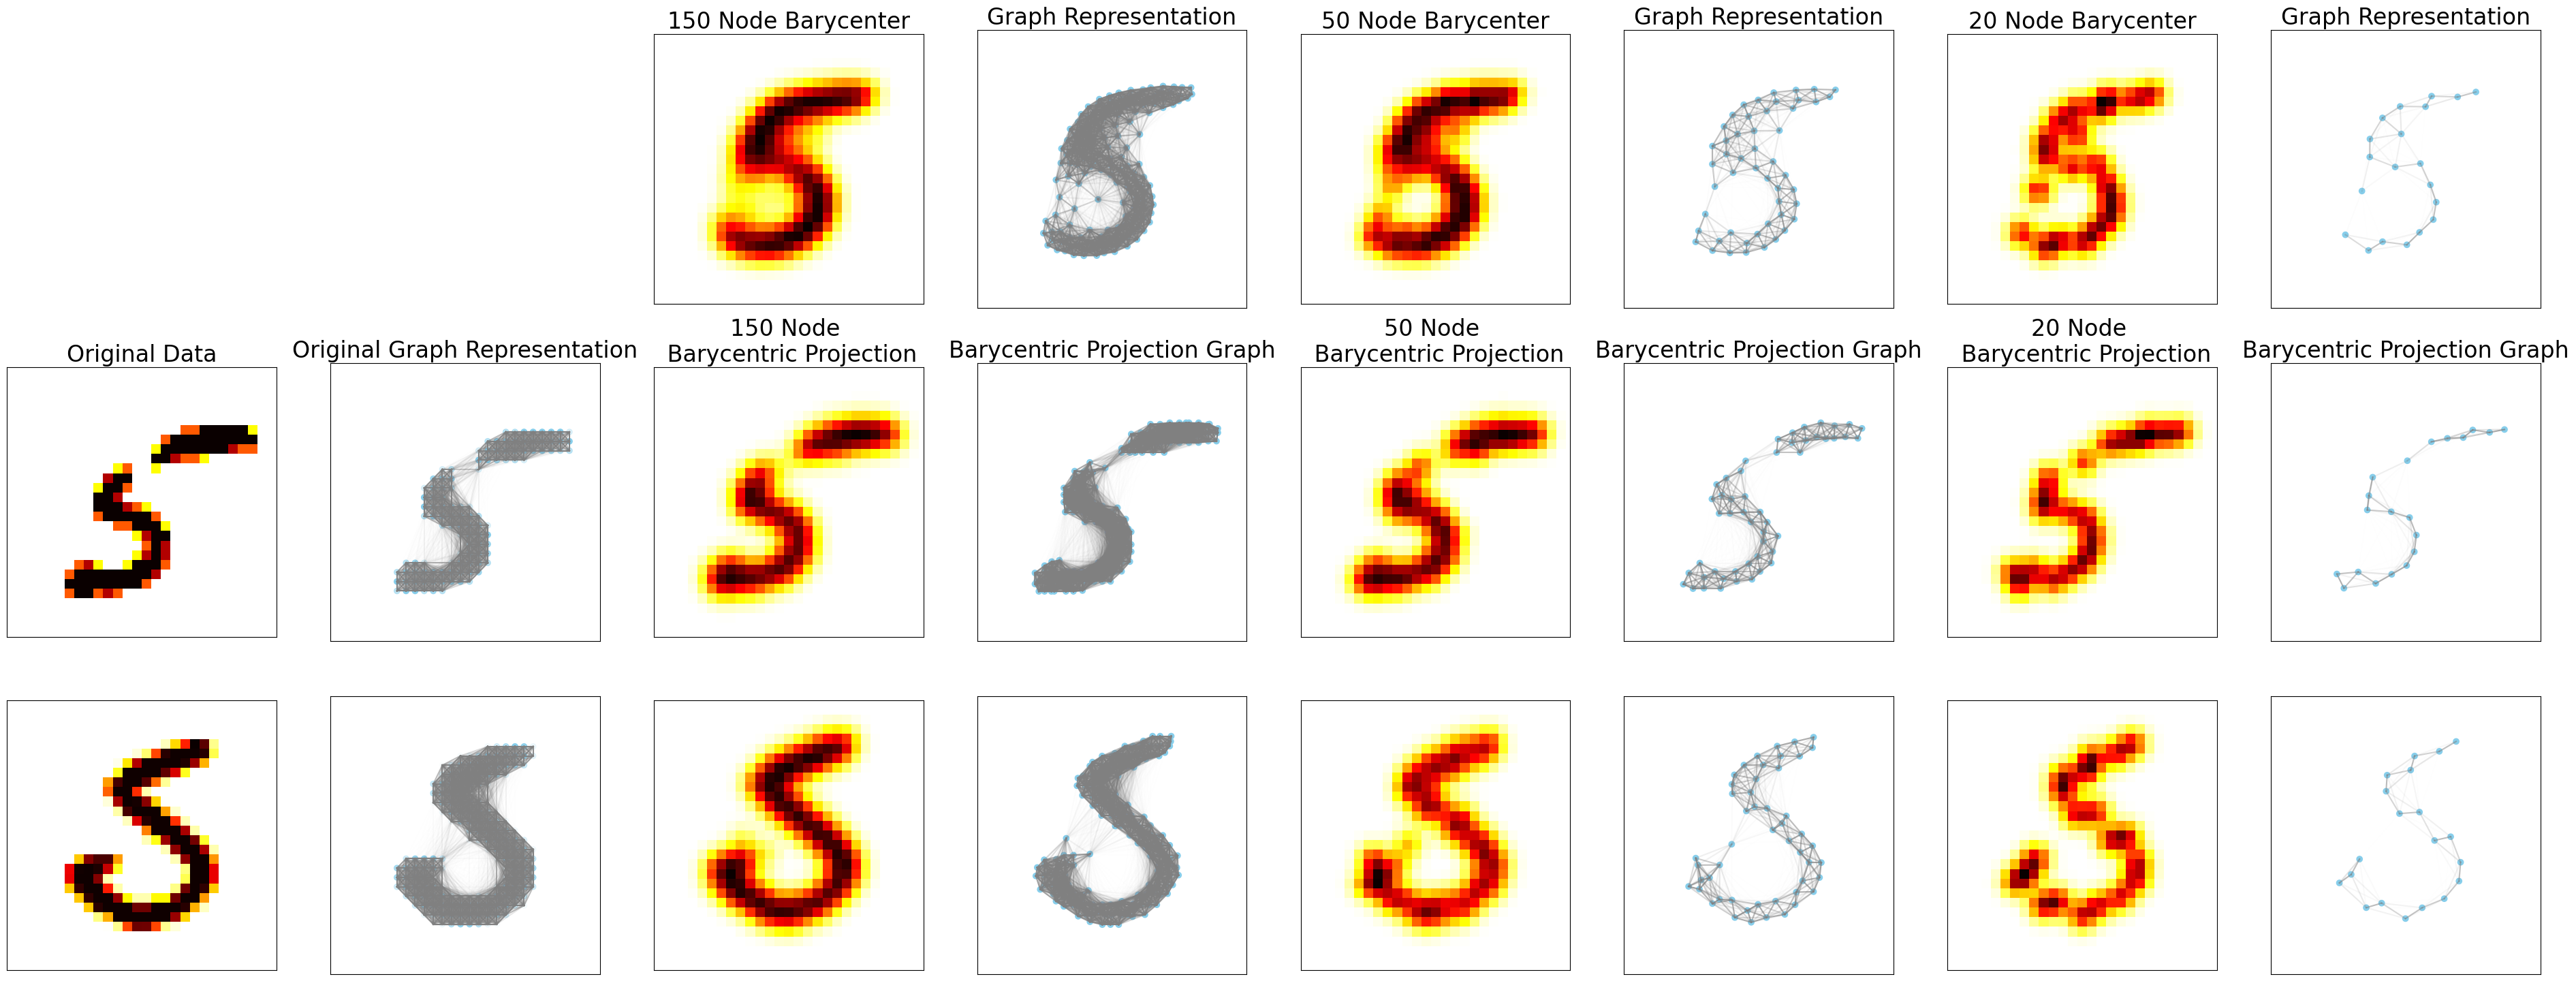

In [11]:
plt.figure(figsize = (48,18))

row1=3
row2=7

fontsize=24

#row0
plt.subplot(3,8,3)
measure(mu150.weights, mu150.locations).plot_barycenter()
plt.xlim(0,28)
plt.ylim(28,0)
plt.title("150 Node Barycenter", fontsize=fontsize)
plt.xticks([])
plt.yticks([])

plt.subplot(3,8,4)
mu150.plot_graph()
plt.xlim(0,28)
plt.ylim(-28,0)
plt.title("Graph Representation", fontsize=fontsize)
plt.xticks([])
plt.yticks([])

plt.subplot(3,8,5)
measure(mu50.weights, mu50.locations).plot_barycenter()
plt.xlim(0,28)
plt.ylim(28,0)
plt.title("50 Node Barycenter", fontsize=fontsize)
plt.xticks([])
plt.yticks([])

plt.subplot(3,8,6)
mu50.plot_graph()
plt.xlim(0,28)
plt.ylim(-28,0)
plt.title("Graph Representation", fontsize=fontsize)
plt.xticks([])
plt.yticks([])


plt.subplot(3,8,7)
measure(mu20.weights, mu20.locations).plot_barycenter()
plt.xlim(0,28)
plt.ylim(28,0)
plt.title("20 Node Barycenter", fontsize=fontsize)
plt.xticks([])
plt.yticks([])

    
plt.subplot(3,8,8)
mu20.plot_graph()
plt.xlim(0,28)
plt.ylim(-28,0)
plt.title("Graph Representation", fontsize=fontsize)
plt.xticks([])
plt.yticks([])


#row1
plt.subplot(3,8,9)
measure_list[row1].imshow()
plt.title("Original Data", fontsize=fontsize)
plt.xticks([])
plt.yticks([])


plt.subplot(3,8,10)
measure_network(measure_list[row1].weights, measure_list[row1].locations, sigma=2).plot_graph()
plt.title("Original Graph Representation", fontsize=fontsize)
plt.xticks([])
plt.yticks([])


plt.subplot(3,8,11)
measure(mu150.weights, nodes150[row1]).plot_barycenter()
plt.xlim(0,28)
plt.ylim(28,0)
plt.title("150 Node \n Barycentric Projection", fontsize=fontsize)
plt.xticks([])
plt.yticks([])


plt.subplot(3,8,12)
bp = measure_network(mu150.weights, nodes150[row1], sigma=2)
bp.D = edges150[row1]
bp.plot_graph()
plt.xlim(0,28)
plt.ylim(-28,0)
plt.title("Barycentric Projection Graph", fontsize=fontsize)
plt.xticks([])
plt.yticks([])


plt.subplot(3,8,13)
measure(mu50.weights, nodes50[row1]).plot_barycenter()
plt.xlim(0,28)
plt.ylim(28,0)
plt.title("50 Node \n Barycentric Projection", fontsize=fontsize)
plt.xticks([])
plt.yticks([])


plt.subplot(3,8,14)
bp = measure_network(mu50.weights, nodes50[row1], sigma=2)
bp.D = edges50[row1]
bp.plot_graph()
plt.xlim(0,28)
plt.ylim(-28,0)
plt.title("Barycentric Projection Graph", fontsize=fontsize)
plt.xticks([])
plt.yticks([])

plt.subplot(3,8,15)
measure(mu20.weights, nodes20[row1]).plot_barycenter()
plt.xlim(0,28)
plt.ylim(28,0)
plt.title("20 Node \n Barycentric Projection", fontsize=fontsize)
plt.xticks([])
plt.yticks([])

plt.subplot(3,8,16)
bp = measure_network(mu20.weights, nodes20[row1], sigma=2)
bp.D = edges20[row1]
bp.plot_graph()
plt.xlim(0,28)
plt.ylim(-28,0)
plt.title("Barycentric Projection Graph", fontsize=fontsize)
plt.xticks([])
plt.yticks([])



#row2
plt.subplot(3,8,17)
measure_list[row2].imshow()
plt.xticks([])
plt.yticks([])

plt.subplot(3,8,18)
measure_network(measure_list[row2].weights, measure_list[row2].locations,sigma=2).plot_graph()
# plt.xlim(0,28)
# plt.ylim(0,28)
plt.xticks([])
plt.yticks([])


plt.subplot(3,8,19)
measure(mu150.weights, nodes150[row2]).plot_barycenter()
plt.xlim(0,28)
plt.ylim(28,0)
plt.xticks([])
plt.yticks([])

plt.subplot(3,8,20)
bp = measure_network(mu150.weights, nodes150[row2], sigma=2)
bp.D = edges150[row2]
bp.plot_graph()
plt.xlim(0,28)
plt.ylim(-28,0)
plt.xticks([])
plt.yticks([])


plt.subplot(3,8,21)
measure(mu50.weights, nodes50[row2]).plot_barycenter()
plt.xlim(0,28)
plt.ylim(28,0)
plt.xticks([])
plt.yticks([])

plt.subplot(3,8,22)
bp = measure_network(mu50.weights, nodes50[row2], sigma=2)
bp.D = edges50[row2]
bp.plot_graph()
plt.xlim(0,28)
plt.ylim(-28,0)
plt.xticks([])
plt.yticks([])

plt.subplot(3,8,23)
measure(mu20.weights, nodes20[row2]).plot_barycenter()
plt.xlim(0,28)
plt.ylim(28,0)
plt.xticks([])
plt.yticks([])

plt.subplot(3,8,24)
bp = measure_network(mu20.weights, nodes20[row2], sigma=2)
bp.D = edges20[row2]
bp.plot_graph()
plt.xlim(0,28)
plt.ylim(-28,0)
plt.xticks([])
plt.yticks([])

# plt.show()
plt.savefig("MNIST_GW_Barycentric_Projections.png", bbox_inches='tight')